<a href="https://colab.research.google.com/github/aditya161205/NLP/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q gdown tqdm scikit-learn matplotlib seaborn torch torchvision
import torch
print(torch.__version__, torch.cuda.is_available())


2.8.0+cu126 True


In [2]:
import gdown, os, zipfile, shutil
file_id = "1A8mqzrqeTUj8Rbh52w0mru_GxONjHVJv"
out = "reviews_dataset"
gdown.download(f"https://drive.google.com/uc?id={file_id}", out, quiet=False)
if zipfile.is_zipfile(out):
    with zipfile.ZipFile(out,"r") as z:
        z.extractall("dataset")
else:
    os.makedirs("dataset", exist_ok=True)
    if os.path.exists(out):
        shutil.move(out, os.path.join("dataset", out))
print(os.listdir("dataset"))


Downloading...
From: https://drive.google.com/uc?id=1A8mqzrqeTUj8Rbh52w0mru_GxONjHVJv
To: /content/reviews_dataset
100%|██████████| 66.2M/66.2M [00:01<00:00, 46.6MB/s]

['reviews_dataset']


In [3]:
import pandas as pd, glob
files = glob.glob("dataset/*")
if len(files)==0:
    raise RuntimeError("put dataset in ./dataset")
f = files[0]
if f.endswith(".csv"):
    df = pd.read_csv(f)
elif f.endswith(".tsv"):
    df = pd.read_csv(f, sep="\t")
elif f.endswith(".json"):
    df = pd.read_json(f, lines=True)
else:
    try:
        df = pd.read_csv(f)
    except:
        df = pd.read_csv(f, header=None)
print("cols", df.columns.tolist())
df = df.rename(columns={df.columns[0]:"text", df.columns[1]:"label"})
df = df[["text","label"]]
df.head()


cols ['review', 'sentiment']


,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
import re
def clean(x):
    x = str(x).lower()
    x = re.sub(r"<.*?>"," ",x)
    x = re.sub(r"[^a-z0-9\s']", " ", x)
    x = re.sub(r"\s+"," ",x).strip()
    return x
df["text"] = df["text"].astype(str)
df["clean"] = df["text"].apply(clean)
df["tokens"] = df["clean"].str.split()
u = df["label"].unique().tolist()
def lab(x):
    s = str(x).lower()
    if s in ("pos","positive","p","1","true","yes"): return 1
    if s in ("neg","negative","n","0","false","no"): return 0
    import re
    m = re.search(r"\d+", s)
    if m: return int(m.group(0))
    if "pos" in s: return 1
    return 0
df["label"] = df["label"].apply(lab).astype(int)
df["label"].value_counts()


,count
label,
1,25000
0,25000


In [5]:
from collections import Counter
all_tokens = [t for toks in df["tokens"] for t in toks]
vc = Counter(all_tokens)
MAX_VOCAB = 30000
most = vc.most_common(MAX_VOCAB)
itos = ["<pad>","<unk>"] + [w for w,_ in most]
stoi = {w:i for i,w in enumerate(itos)}
PAD_IDX = 0
UNK_IDX = 1


In [6]:
MAX_LEN = 200
def toks2idx(toks):
    return [stoi.get(t, UNK_IDX) for t in toks]
df["idxs"] = df["tokens"].apply(toks2idx)
from sklearn.model_selection import train_test_split
tr, te = train_test_split(df, test_size=0.15, random_state=42, stratify=df["label"])
tr, va = train_test_split(tr, test_size=0.15, random_state=42, stratify=tr["label"])
len(tr), len(va), len(te)


(36125, 6375, 7500)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
def pad(seq, L=MAX_LEN, padv=PAD_IDX):
    if len(seq)>=L:
        return seq[:L]
    return seq + [padv]*(L-len(seq))
class RDataset(Dataset):
    def __init__(self, df):
        self.X = df["idxs"].tolist()
        self.y = df["label"].tolist()
    def __len__(self): return len(self.y)
    def __getitem__(self,i): return self.X[i], self.y[i]
def collate(b):
    xs, ys = zip(*b)
    Ls = [min(len(x), MAX_LEN) for x in xs]
    xs = [pad(x) for x in xs]
    return torch.LongTensor(xs), torch.LongTensor(Ls), torch.FloatTensor(ys)
BATCH = 64
train_dl = DataLoader(RDataset(tr), batch_size=BATCH, shuffle=True, collate_fn=collate)
val_dl = DataLoader(RDataset(va), batch_size=BATCH, shuffle=False, collate_fn=collate)
test_dl = DataLoader(RDataset(te), batch_size=BATCH, shuffle=False, collate_fn=collate)


In [8]:
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, vocab, emb=200, hid=128, layers=1, drop=0.3, ty="rnn", bid=False):
        super().__init__()
        self.e = nn.Embedding(vocab, emb, padding_idx=PAD_IDX)
        if ty=="rnn":
            self.r = nn.RNN(emb, hid, layers, batch_first=True, dropout=drop, bidirectional=bid)
        else:
            self.r = nn.LSTM(emb, hid, layers, batch_first=True, dropout=drop, bidirectional=bid)
        self.bid = bid
        self.ty = ty
        self.fc = nn.Sequential(nn.Linear(hid*(2 if bid else 1), hid//2), nn.ReLU(), nn.Dropout(drop), nn.Linear(hid//2,1))
    def forward(self, x, lengths):
        emb = self.e(x)
        lengths_sorted, idx = lengths.sort(0, descending=True)
        emb_s = emb[idx]
        packed = nn.utils.rnn.pack_padded_sequence(emb_s, lengths_sorted.cpu(), batch_first=True, enforce_sorted=True)
        out, hid = self.r(packed)
        if self.ty=="lstm":
            h,_ = hid
        else:
            h = hid
        if self.bid:
            last = torch.cat((h[-2], h[-1]), dim=1)
        else:
            last = h[-1]
        _, un = idx.sort(0)
        last = last[un]
        return self.fc(last).squeeze(1)
def build(v, ty="rnn", bid=False):
    return Model(v, emb=200, hid=128, layers=1, drop=0.3, ty=ty, bid=bid)


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np, torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_epoch(m, dl, opt, crit):
    m.train()
    tot = 0
    preds=[]
    labs=[]
    for x, L, y in dl:
        x, L, y = x.to(device), L.to(device), y.to(device)
        opt.zero_grad()
        out = m(x, L)
        loss = crit(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
        opt.step()
        tot += loss.item()*x.size(0)
        p = (torch.sigmoid(out).detach().cpu().numpy()>=0.5).astype(int)
        preds += p.tolist()
        labs += y.detach().cpu().numpy().astype(int).tolist()
    return tot/len(dl.dataset), accuracy_score(labs, preds)
def eval_model(m, dl, crit):
    m.eval()
    tot=0
    probs=[]
    preds=[]
    labs=[]
    with torch.no_grad():
        for x,L,y in dl:
            x,L,y = x.to(device), L.to(device), y.to(device)
            out = m(x,L)
            loss = crit(out,y)
            tot += loss.item()*x.size(0)
            p = torch.sigmoid(out).detach().cpu().numpy()
            preds += (p>=0.5).astype(int).tolist()
            probs += p.tolist()
            labs += y.detach().cpu().numpy().astype(int).tolist()
    res = {}
    res["loss"]=tot/len(dl.dataset)
    res["acc"]=accuracy_score(labs, preds)
    res["prec"]=precision_score(labs, preds, zero_division=0)
    res["rec"]=recall_score(labs, preds, zero_division=0)
    res["f1"]=f1_score(labs, preds, zero_division=0)
    res["probs"]=np.array(probs)
    res["preds"]=np.array(preds)
    res["labs"]=np.array(labs)
    res["cm"]=confusion_matrix(labs, preds)
    return res


In [10]:
import time
def run_train(model, epochs=6, lr=1e-3):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCEWithLogitsLoss()
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for e in range(epochs):
        tl, ta = train_epoch(model, train_dl, opt, crit)
        v = eval_model(model, val_dl, crit)
        history["train_loss"].append(tl)
        history["train_acc"].append(ta)
        history["val_loss"].append(v["loss"])
        history["val_acc"].append(v["acc"])
        print(e, "train_loss", round(tl,4), "train_acc", round(ta,4), "val_loss", round(v["loss"],4), "val_acc", round(v["acc"],4))
    return model, history


In [11]:
vocab = len(itos)
rnn = build(vocab, ty="rnn", bid=False)
lstm = build(vocab, ty="lstm", bid=False)
bilstm = build(vocab, ty="lstm", bid=True)
rnn, hr = run_train(rnn, epochs=6, lr=1e-3)
lstm, hl = run_train(lstm, epochs=6, lr=1e-3)
bilstm, hb = run_train(bilstm, epochs=6, lr=1e-3)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


0 train_loss 0.6502 train_acc 0.6154 val_loss 0.6364 val_acc 0.6761
1 train_loss 0.5694 train_acc 0.7174 val_loss 0.5452 val_acc 0.7242
2 train_loss 0.5285 train_acc 0.7508 val_loss 0.5562 val_acc 0.7175
3 train_loss 0.4609 train_acc 0.7945 val_loss 0.5455 val_acc 0.7297
4 train_loss 0.4074 train_acc 0.824 val_loss 0.5119 val_acc 0.766
5 train_loss 0.357 train_acc 0.8527 val_loss 0.5364 val_acc 0.7584
0 train_loss 0.5855 train_acc 0.6868 val_loss 0.5145 val_acc 0.7688
1 train_loss 0.4127 train_acc 0.8261 val_loss 0.4115 val_acc 0.8246
2 train_loss 0.3061 train_acc 0.8796 val_loss 0.3795 val_acc 0.8315
3 train_loss 0.2208 train_acc 0.9166 val_loss 0.344 val_acc 0.8595
4 train_loss 0.1469 train_acc 0.9463 val_loss 0.4135 val_acc 0.8593
5 train_loss 0.0895 train_acc 0.9681 val_loss 0.5259 val_acc 0.8612
0 train_loss 0.5549 train_acc 0.704 val_loss 0.4581 val_acc 0.7889
1 train_loss 0.3518 train_acc 0.8498 val_loss 0.3542 val_acc 0.8438
2 train_loss 0.2446 train_acc 0.9049 val_loss 0.3885 

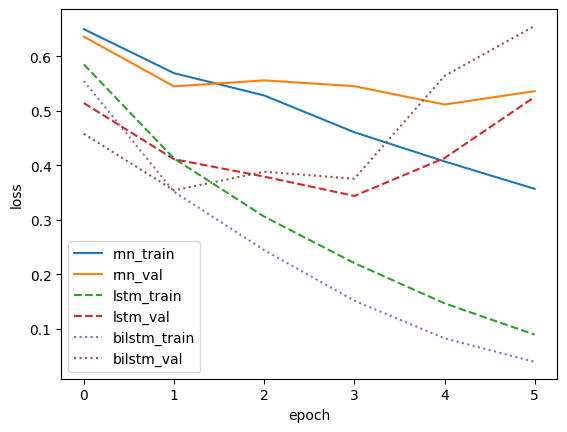

In [12]:
import matplotlib.pyplot as plt
plt.plot(hr["train_loss"], label="rnn_train"); plt.plot(hr["val_loss"], label="rnn_val")
plt.plot(hl["train_loss"], label="lstm_train", linestyle="--"); plt.plot(hl["val_loss"], label="lstm_val", linestyle="--")
plt.plot(hb["train_loss"], label="bilstm_train", linestyle=":"); plt.plot(hb["val_loss"], label="bilstm_val", linestyle=":")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()


In [13]:
crit = nn.BCEWithLogitsLoss()
r_res = eval_model(rnn, test_dl, crit)
l_res = eval_model(lstm, test_dl, crit)
b_res = eval_model(bilstm, test_dl, crit)
print("RNN", r_res["acc"], r_res["prec"], r_res["rec"], r_res["f1"])
print("LSTM", l_res["acc"], l_res["prec"], l_res["rec"], l_res["f1"])
print("BiLSTM", b_res["acc"], b_res["prec"], b_res["rec"], b_res["f1"])
print("RNN CM\n", r_res["cm"])
print("LSTM CM\n", l_res["cm"])
print("BiLSTM CM\n", b_res["cm"])


RNN 0.7716 0.7825242718446602 0.7522666666666666 0.7670972127804215
LSTM 0.8662666666666666 0.8695184288404627 0.8618666666666667 0.8656756394803803
BiLSTM 0.8546666666666667 0.8522245762711864 0.8581333333333333 0.8551687483390912
RNN CM
 [[2966  784]
 [ 929 2821]]
LSTM CM
 [[3265  485]
 [ 518 3232]]
BiLSTM CM
 [[3192  558]
 [ 532 3218]]


In [14]:
probs_r = r_res["probs"]
probs_l = l_res["probs"]
probs_b = b_res["probs"]
avg_probs = (probs_r + probs_l + probs_b)/3.0
avg_preds = (avg_probs>=0.5).astype(int)
maj_preds = ( (probs_r>=0.5).astype(int) + (probs_l>=0.5).astype(int) + (probs_b>=0.5).astype(int) )>=2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
labs = r_res["labs"]
print("Ensemble avg", accuracy_score(labs, avg_preds), precision_score(labs, avg_preds, zero_division=0), recall_score(labs, avg_preds, zero_division=0), f1_score(labs, avg_preds, zero_division=0))
print("Ensemble maj", accuracy_score(labs, maj_preds), precision_score(labs, maj_preds, zero_division=0), recall_score(labs, maj_preds, zero_division=0), f1_score(labs, maj_preds, zero_division=0))


Ensemble avg 0.8710666666666667 0.8753709198813057 0.8653333333333333 0.8703231862679361
Ensemble maj 0.8653333333333333 0.8706709956709957 0.8581333333333333 0.8643567015847435


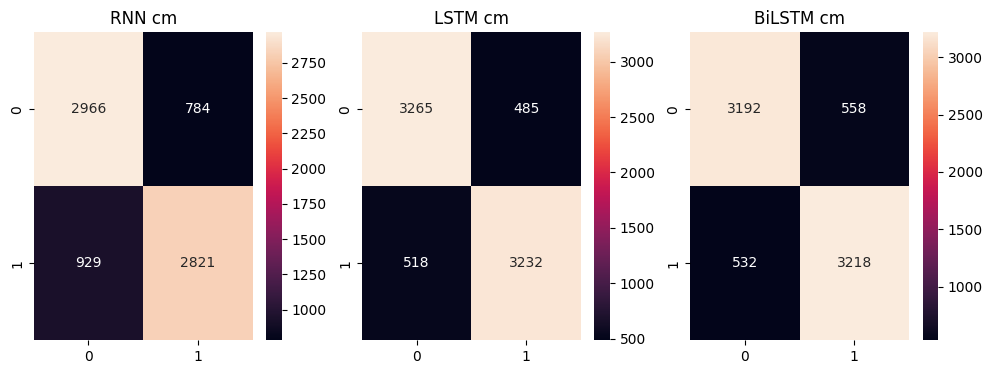

In [15]:
import seaborn as sns
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.heatmap(r_res["cm"], annot=True, fmt="d"); plt.title("RNN cm")
plt.subplot(1,3,2)
sns.heatmap(l_res["cm"], annot=True, fmt="d"); plt.title("LSTM cm")
plt.subplot(1,3,3)
sns.heatmap(b_res["cm"], annot=True, fmt="d"); plt.title("BiLSTM cm")
plt.show()


In [17]:

print("preprocessing: lowercase, remove non-alnum, tokenize, vocab top", MAX_VOCAB)
print("models: basic rnn, lstm, bidirectional lstm")
print("final metrics:")
print("RNN", r_res["acc"], r_res["prec"], r_res["rec"], r_res["f1"])
print("LSTM", l_res["acc"], l_res["prec"], l_res["rec"], l_res["f1"])
print("BiLSTM", b_res["acc"], b_res["prec"], b_res["rec"], b_res["f1"])



preprocessing: lowercase, remove non-alnum, tokenize, vocab top 30000
models: basic rnn, lstm, bidirectional lstm
final metrics:
RNN 0.7716 0.7825242718446602 0.7522666666666666 0.7670972127804215
LSTM 0.8662666666666666 0.8695184288404627 0.8618666666666667 0.8656756394803803
BiLSTM 0.8546666666666667 0.8522245762711864 0.8581333333333333 0.8551687483390912
